# Crash Attribute Segmentation of New Jersey State Vehicle Accident Data
## 4. PCA & K-Means Clustering using SciKit-Learn (refinement step)

This notebook outlines the process of performing Principle Component Analysis (PCA) on the normalized Accident table generated from the previous notebook and training a SageMaker K-Means algorithm to cluster municipalities with similar crash attributes. The goal of this process is to identify crash patterns across multiple municipalities within New Jersey.

### Accidents Data
The raw data used for this notebook was processed in the previous notebook which grouped individual crash cases by county-municipality and normalized all crash attribute columns.

### Machine Learning Workflow
The steps for PCA and K-Means training using SciKit-Learn are as follows:
1. Dimensionality reduction with PCA
2. Feature engineering and data transformation
3. Clustering transformed data with k-means
4. Extracting trained model attributes and visualizing k clusters

### Analysis of Results
After training PCA and K-means models from both SageMaker and SciKit-Learn, an analysis of both methods will be documented in the Capstone report.

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

#scikit learn libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Load Normalized Accidents Table
Load in CSV containing normalized Accident data.

In [2]:
crash_data_file = 'data/accidents_normalized_severity.csv'
# create a dataframe
crash_data_scaled = pd.read_csv(crash_data_file, header=0, delimiter=",") 
crash_data_scaled = crash_data_scaled.set_index('location')
print(crash_data_scaled.index)
print(crash_data_scaled.columns)
print(crash_data_scaled.shape)
crash_data_scaled.head()

Index(['ATLANTIC-ABSECON CITY', 'ATLANTIC-ATLANTIC CITY',
       'ATLANTIC-BUENA BORO', 'ATLANTIC-BUENA VISTA TWP',
       'ATLANTIC-EGG HARBOR CITY', 'ATLANTIC-EGG HARBOR TWP',
       'ATLANTIC-ESTELL MANOR CITY', 'ATLANTIC-FOLSOM BORO',
       'ATLANTIC-GALLOWAY TWP', 'ATLANTIC-HAMILTON TWP',
       ...
       'WARREN-KNOWLTON TWP', 'WARREN-LIBERTY TWP', 'WARREN-LOPATCONG TWP',
       'WARREN-MANSFIELD TWP', 'WARREN-OXFORD TWP', 'WARREN-PHILLIPSBURG TOWN',
       'WARREN-POHATCONG TWP', 'WARREN-WASHINGTON BORO',
       'WARREN-WASHINGTON TWP', 'WARREN-WHITE TWP'],
      dtype='object', name='location', length=511)
Index(['severity_rating5_4', 'severity_rating5_5', 'intersection_N',
       'intersection_Y', 'alcohol_involved_N', 'alcohol_involved_Y',
       'hazmat_involved_N', 'hazmat_involved_Y', 'hs_collision_type_1',
       'hs_collision_type_2',
       ...
       'first_harmful_event_57.0', 'first_harmful_event_58.0',
       'first_harmful_event_59.0', 'first_harmful_event_60.0',

,severity_rating5_4,severity_rating5_5,intersection_N,intersection_Y,alcohol_involved_N,alcohol_involved_Y,hazmat_involved_N,hazmat_involved_Y,hs_collision_type_1,hs_collision_type_2,...,first_harmful_event_57.0,first_harmful_event_58.0,first_harmful_event_59.0,first_harmful_event_60.0,first_harmful_event_61.0,first_harmful_event_62.0,first_harmful_event_69.0,first_harmful_event_99.0,flg_cell_in_use_N,flg_cell_in_use_Y
location,,,,,,,,,,,,,,,,,,,,,
ATLANTIC-ABSECON CITY,0.031250,0.066667,0.053571,0.026316,0.017647,0.227273,0.037433,0.0,0.045455,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.037838,0.000000
ATLANTIC-ATLANTIC CITY,0.250000,0.100000,0.223214,0.171053,0.164706,0.454545,0.197861,0.0,0.166667,0.206349,...,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.194595,0.333333
ATLANTIC-BUENA BORO,0.015625,0.016667,0.017857,0.013158,0.017647,0.000000,0.010695,0.0,0.000000,0.031746,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010811,0.000000
ATLANTIC-BUENA VISTA TWP,0.070312,0.100000,0.107143,0.039474,0.076471,0.090909,0.074866,0.0,0.015152,0.047619,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.075676,0.000000
ATLANTIC-EGG HARBOR CITY,0.039062,0.066667,0.026786,0.078947,0.047059,0.045455,0.042781,0.0,0.030303,0.063492,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.043243,0.000000


## 1. Dimensionality reduction with PCA
With 175 columns, it would be hard for a K-Means algorithm to cluster meaningful crash attributes. We only want attributes that hold meaningful weights and disregard those that are not importaint. To do this, the data will be dimensionally reduced using the SciKit-Learn model for PCA.

### 1.1 Define the PCA model and train

In [3]:
# N_COMPONENTS is current features - 1
# only a portion of these will be selected to use later
N_COMPONENTS = crash_data_scaled.columns.size - 1

pca = PCA(n_components = N_COMPONENTS)
print('\nPCA Parameters:', pca, '\n')



PCA Parameters: PCA(copy=True, iterated_power='auto', n_components=174, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) 



In [4]:
pca.fit(crash_data_scaled)
print('\nArray Containing all Principal Components:\n', pca.components_)
print('\nFirst Principal Component:', pca.components_[0])
print('Second Principal Component:', pca.components_[1])
print('\nEigenvalues:', pca.singular_values_)
print('\nPercentage of Variance Explained by Each Principal Component:', pca.explained_variance_ratio_)


Array Containing all Principal Components:
 [[ 1.14478121e-01  1.42293531e-01  1.40607285e-01 ...  6.17654544e-02
   1.24219388e-01  7.00748907e-02]
 [ 6.00340289e-02 -2.25015915e-02 -7.06268706e-03 ...  1.09092710e-01
   3.36491614e-02  3.63884536e-02]
 [ 4.18738925e-02  4.94860757e-03 -1.14591561e-02 ... -9.58110560e-02
   3.08347311e-02 -1.58835202e-02]
 ...
 [-0.00000000e+00 -1.56125113e-16  1.15132160e-02 ... -1.72480117e-04
  -5.36475434e-01 -8.69960163e-03]
 [-0.00000000e+00 -3.55452891e-17 -1.46193854e-02 ... -3.84254665e-04
  -4.21051215e-01 -6.82785754e-03]
 [-0.00000000e+00 -9.30054885e-17  7.47045791e-03 ... -1.96922736e-03
   1.08048887e-01  1.75214411e-03]]

First Principal Component: [ 1.14478121e-01  1.42293531e-01  1.40607285e-01  9.79315195e-02
  1.15458295e-01  1.61950055e-01  1.23590272e-01  2.64768497e-02
  7.04873156e-02  1.23283581e-01  7.66442121e-02  1.44549700e-01
  9.57186972e-02  1.17157574e-02  1.29394879e-01  1.14060291e-02
  5.82072112e-03  1.39572833e-0


## 2. Feature engineering and data transformation
Based on the chosen 'N_COMPONENTS' value chosen, the PCA model created 174 components. The goal of PCA is to reduce the number of components such that the top n chosen components make up 70% data varience. This section details this process.
### 2.1 PCA Model Attributes

Two types of model attributes are contained within the PCA model:

* **pca.components_**: The makeup of the principal components.
* **explained_variance_ratio_**: Percentage of variance explained by each of the selected components.
    
In this project, the top n principle components will be chosen that account for 70% data varience. To choose "n", the explained varience is calculated by summing n component's explained varience until the sum reaches ~70%.

In [5]:
# get selected params
v = pd.DataFrame(pca.components_) # the makeups of each component
s = pd.DataFrame(pca.explained_variance_ratio_) # explained varience ratio
s.head()

,0
0,0.320972
1,0.046702
2,0.029873
3,0.024734
4,0.021892


In [6]:
print(v.shape)
v.head()


(174, 175)


,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,0.114478,0.142294,0.140607,0.097932,0.115458,0.161950,0.123590,0.026477,0.070487,0.123284,...,0.044623,0.041861,0.037540,0.122854,0.024907,0.008650,0.043555,0.061765,0.124219,0.070075
1,0.060034,-0.022502,-0.007063,0.093754,0.044588,-0.056626,0.033725,0.009259,0.093816,0.111492,...,0.008688,-0.107332,0.073538,-0.265380,-0.042443,0.024651,0.056925,0.109093,0.033649,0.036388
2,0.041874,0.004949,-0.011459,0.091318,0.032572,0.005437,0.029495,0.047098,0.038157,0.057140,...,-0.061635,-0.106190,-0.026187,0.013614,0.061444,0.022915,0.064345,-0.095811,0.030835,-0.015884
3,0.010487,-0.009632,-0.016588,0.034503,0.010775,-0.048516,0.004299,-0.013190,0.045981,0.008709,...,0.122787,0.036141,0.050220,0.011184,0.045104,-0.031485,-0.013394,-0.038472,0.002402,0.106690
4,-0.006397,0.052023,0.020084,0.000699,0.016746,-0.024741,0.012762,-0.028007,0.041719,0.000379,...,0.313113,-0.081501,0.025540,0.077512,-0.027926,-0.023491,-0.031012,0.275457,0.011842,0.037266


### 2.2 Data Variance
For a SciKit-Learn PCA model, the top 's' values start at the beginning. 's' values are defined as the percentage of variance explained by each of the selected components.

In [7]:
# looking at top 5 components
n_principal_components = 5

# print a selection of s
print(s.iloc[:n_principal_components])

          0
0  0.320972
1  0.046702
2  0.029873
3  0.024734
4  0.021892


### 2.3 Calculating the explained variance
In this project, the top n principle components will be chosen that account for 70% data varience. To choose "n", the explained varience will be calculated by summing each component's varience from the top until it reaches ~70%.

Using this formula, an "n" of 25 resulted in 71% data varience.

In [8]:
# Calculate the explained variance for the top n principal components
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    # calculate approx variance
    exp_variance = s.iloc[:n_top_components].sum()
    
    return exp_variance[0]


In [167]:
n_top_components = 15 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.6028814036397393


### 2.4 Component Makeup
The following code examines the makeup of each PCA component based on the weightings of the original features that are included in the component. 
To reuse the `display_component` function from the previous notebook, the v dataframe was transposed such that features (175) are rows and components (174) are columns. 

In [168]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (component_num)
    row_idx = component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    ##print(v_1_row)
    v_1 = np.squeeze(v_1_row.values)
    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [169]:
transpose_v = v.T
print(transpose_v.shape)
transpose_v.iloc[:,:]

(175, 174)


,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,173
0,0.114478,0.060034,0.041874,0.010487,-0.006397,-0.002449,0.003584,-0.007228,-0.019929,0.000158,...,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
1,0.142294,-0.022502,0.004949,-0.009632,0.052023,0.014285,0.017964,0.025835,-0.004464,-0.018088,...,6.598231e-16,-2.030788e-17,-6.304073e-16,4.423593e-17,3.191891e-16,-9.714451e-17,5.134781e-16,-1.561251e-16,-3.554529e-17,-9.300549e-17
2,0.140607,-0.007063,-0.011459,-0.016588,0.020084,-0.009757,0.008860,0.007800,-0.014043,-0.010007,...,-1.610485e-01,5.481607e-03,1.390027e-01,-3.188633e-02,-3.478497e-01,4.520210e-01,-6.824259e-02,1.151322e-02,-1.461939e-02,7.470458e-03
3,0.097932,0.093754,0.091318,0.034503,0.000699,0.021530,0.007160,-0.003272,-0.016394,0.000733,...,-1.092829e-01,3.719662e-03,9.432328e-02,-2.163715e-02,-2.360409e-01,3.067285e-01,-4.630747e-02,7.812539e-03,-9.920297e-03,5.069239e-03
4,0.115458,0.044588,0.032572,0.010775,0.016746,0.000513,0.010231,0.012269,-0.021428,-0.006387,...,6.085448e-01,1.734107e-01,3.411702e-01,-3.386919e-02,-1.771952e-01,-2.828648e-01,-1.557551e-01,3.594230e-01,-1.222633e-01,1.049112e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.008650,0.024651,0.022915,-0.031485,-0.023491,0.016071,-0.007805,0.015610,-0.007412,-0.036762,...,-2.068921e-03,5.541651e-03,-1.681401e-03,1.334333e-03,-7.810909e-03,-1.129978e-03,1.103570e-02,-3.449602e-04,-7.685093e-04,-3.938455e-03
171,0.043555,0.056925,0.064345,-0.013394,-0.031012,0.129579,-0.006017,0.003397,-0.062419,0.020494,...,-4.137842e-03,1.108330e-02,-3.362802e-03,2.668666e-03,-1.562182e-02,-2.259957e-03,2.207140e-02,-6.899205e-04,-1.537019e-03,-7.876909e-03
172,0.061765,0.109093,-0.095811,-0.038472,0.275457,-0.311724,-0.162654,-0.077225,0.289692,0.400786,...,-1.034460e-03,2.770826e-03,-8.407005e-04,6.671664e-04,-3.905454e-03,-5.649891e-04,5.517849e-03,-1.724801e-04,-3.842547e-04,-1.969227e-03
173,0.124219,0.033649,0.030835,0.002402,0.011842,0.002231,0.008211,0.004149,-0.014991,-0.005596,...,3.440764e-01,-3.463416e-01,1.209456e-02,-1.376772e-01,-1.086922e-01,5.172968e-02,5.288615e-02,-5.364754e-01,-4.210512e-01,1.080489e-01


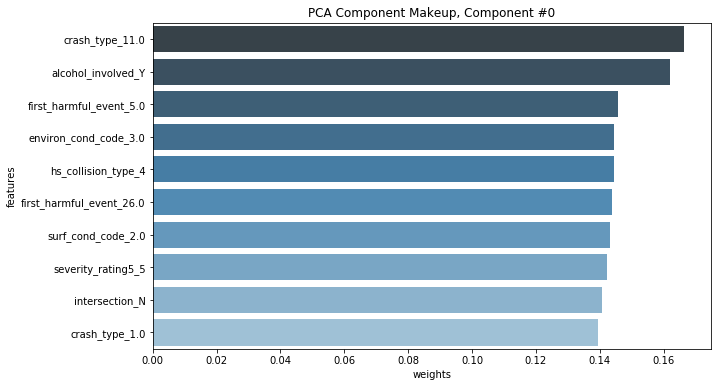

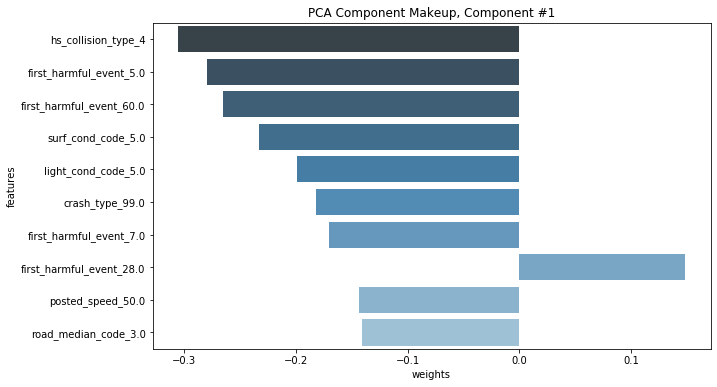

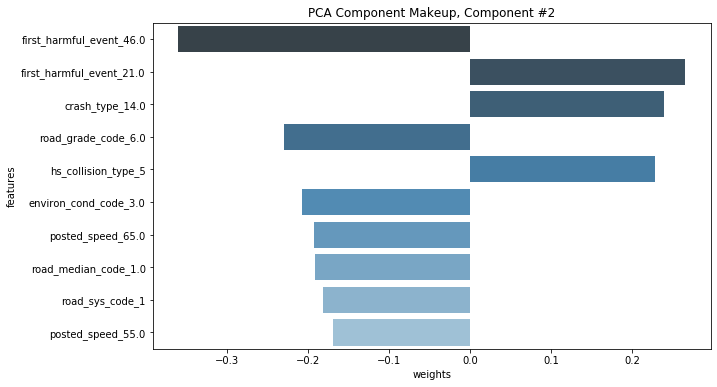

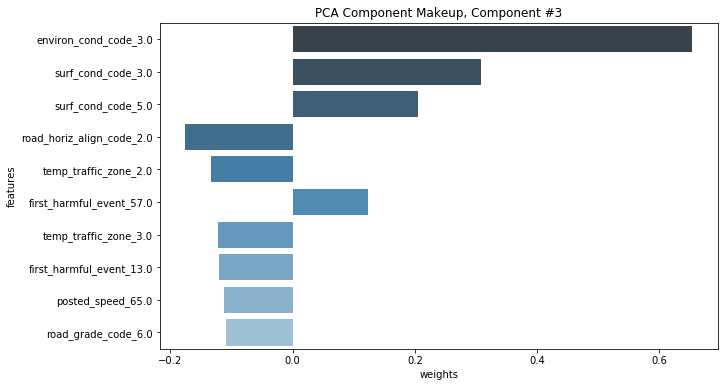

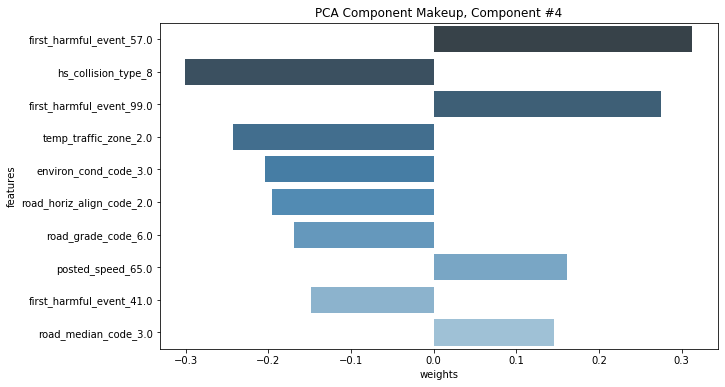

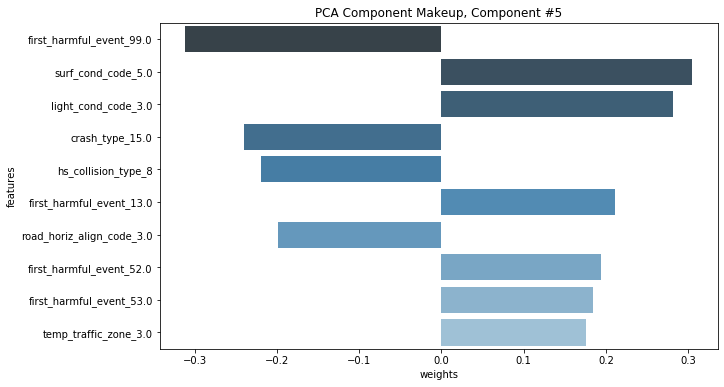

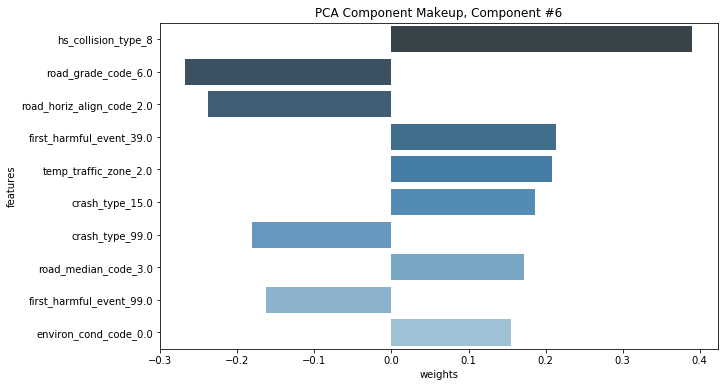

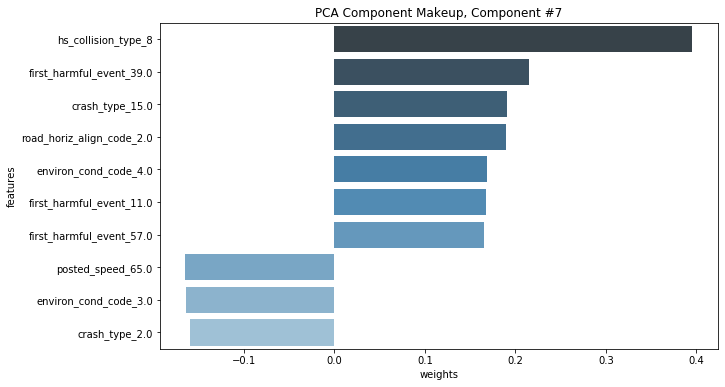

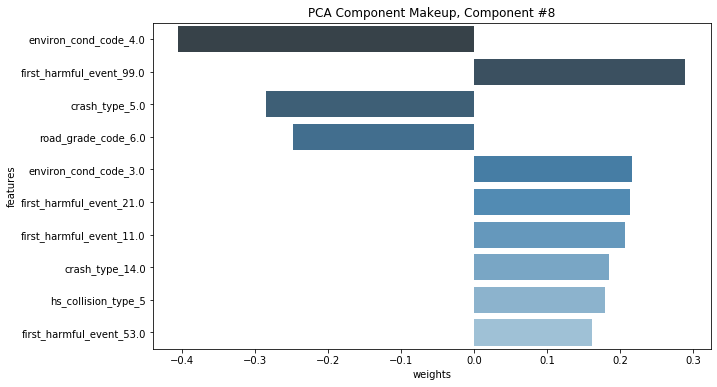

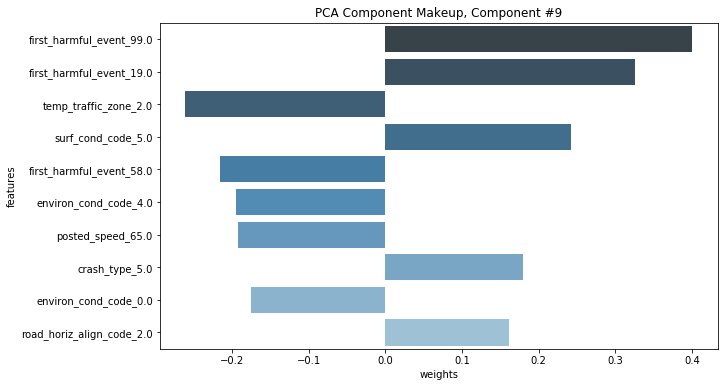

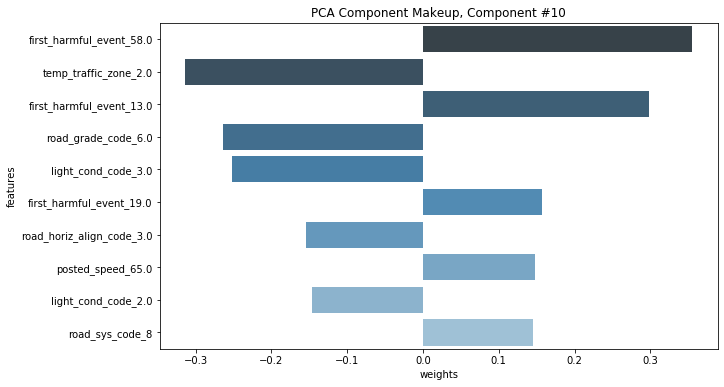

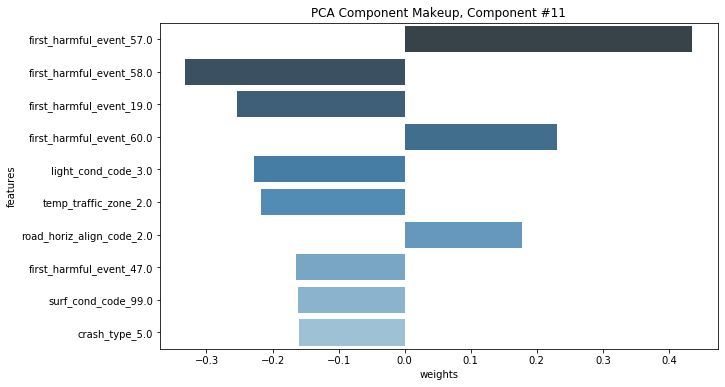

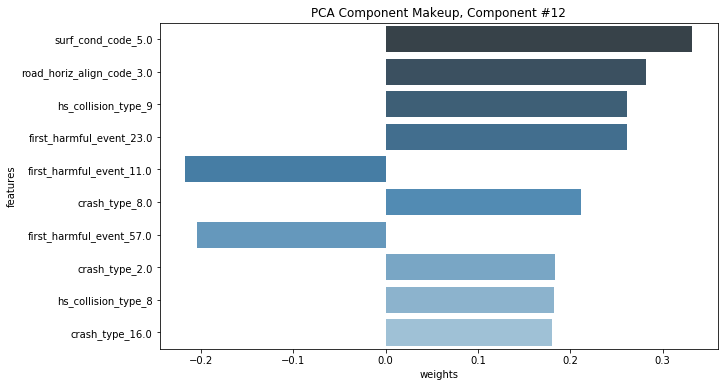

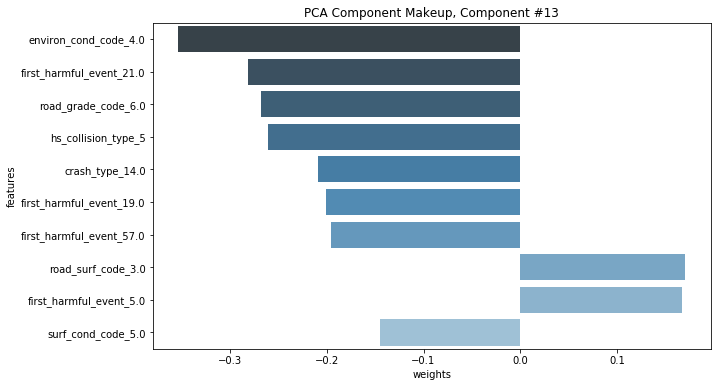

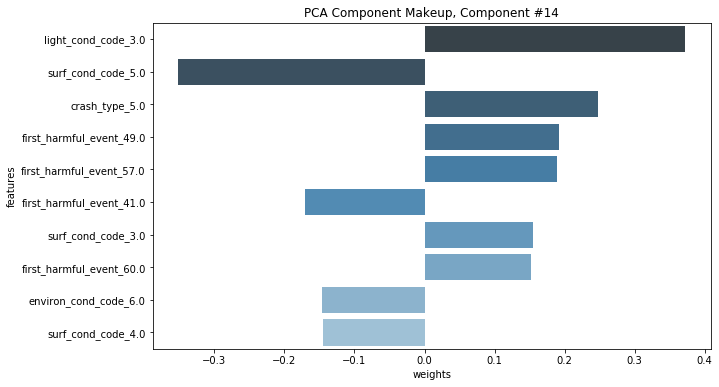

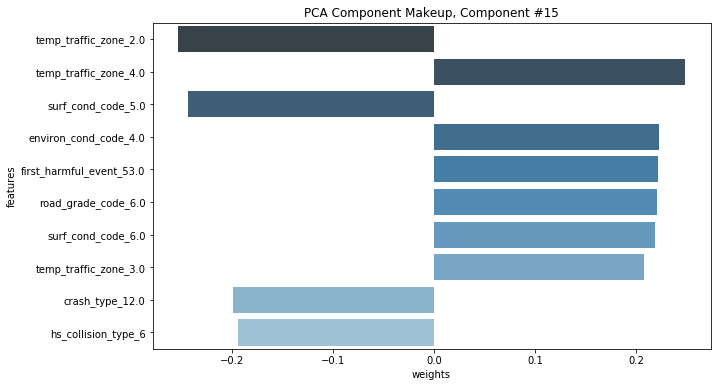

In [170]:
# display makeup of first component
for num in range(16):
    display_component(transpose_v, crash_data_scaled.columns.values, component_num=num)

### 2.5 Dimensionally reduce the PCA components
The code in this section details how the resulting PCA components were reduced to the top n components. A dataframe is created based on the top n components for each county-municipality data point.

In [171]:
data_transformed = pca.transform(crash_data_scaled) # returns shape (n_samples, n_components)
transformed_df = pd.DataFrame(data_transformed)

In [172]:
print(transformed_df.shape)
transformed_df.head()

(511, 174)


,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,173
0,-0.258861,0.014501,0.020325,-0.081433,0.048150,-0.057623,-0.057928,0.035114,0.107243,0.033827,...,-5.188394e-17,-8.444311e-17,5.075535e-17,-1.021264e-16,-1.666772e-16,1.995995e-16,-9.256717e-17,9.291605e-17,8.610045e-17,3.019358e-17
1,0.771225,0.359157,0.287680,-0.001793,0.044035,0.114233,-0.073310,-0.182439,-0.130033,0.105368,...,1.782612e-16,5.723955e-17,2.809990e-16,-7.591970e-17,-5.648966e-17,-6.993515e-17,-8.157567e-18,-1.325274e-16,-2.104651e-16,-1.726705e-16
2,-0.378835,-0.072236,-0.075397,0.435153,-0.122853,0.010625,0.051016,-0.115615,0.131223,0.026250,...,-1.900655e-16,-3.286219e-17,4.022844e-18,-4.070637e-17,-3.483823e-17,9.903296e-17,1.839739e-18,-5.968540e-17,-2.248239e-17,7.633993e-17
3,0.112528,-0.313396,-0.036641,0.397123,-0.139602,0.076991,-0.046225,-0.126018,0.151448,0.113910,...,-7.416430e-17,-8.769572e-17,1.701464e-17,-1.263041e-16,-1.695097e-16,2.428399e-17,1.960881e-16,-1.515715e-16,3.812451e-17,1.215105e-16
4,-0.311690,0.010645,0.136297,0.008828,0.004250,-0.017810,0.018226,-0.038281,-0.047999,0.021742,...,-8.050688e-17,-1.562338e-17,1.836819e-17,1.126757e-17,-1.581048e-17,5.670164e-17,-2.195850e-17,-2.217201e-17,-4.671431e-17,3.359526e-17


In [173]:
# create dimensionality-reduced data. this function keeps the top n-component columns and applies the 
# county-muni titles as the returned dataframe's index 

def create_transformed_df(transformed_df, crash_data_scaled, n_top_components):
    # create new dataframe to add data to
    crash_transformed = pd.DataFrame()
    
    # capture columns before n_top_components
    crash_transformed = transformed_df.iloc[:, :n_top_components]
    crash_transformed.index=crash_data_scaled.index
    
    return crash_transformed

In [174]:
crash_data_transform = create_transformed_df(transformed_df, crash_data_scaled, n_top_components)
PCA_list = []
# add descriptive columns
for x in range(n_top_components):
    num = x + 1
    PCA_list.append("c_" + str(num))

#PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13']
print(PCA_list)
crash_data_transform.columns = PCA_list 

crash_data_transform.head()

['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15']


,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15
location,,,,,,,,,,,,,,,
ATLANTIC-ABSECON CITY,-0.258861,0.014501,0.020325,-0.081433,0.048150,-0.057623,-0.057928,0.035114,0.107243,0.033827,-0.047761,-0.026248,-0.164275,0.035154,-0.130578
ATLANTIC-ATLANTIC CITY,0.771225,0.359157,0.287680,-0.001793,0.044035,0.114233,-0.073310,-0.182439,-0.130033,0.105368,-0.176877,0.006832,0.227367,0.167209,0.126714
ATLANTIC-BUENA BORO,-0.378835,-0.072236,-0.075397,0.435153,-0.122853,0.010625,0.051016,-0.115615,0.131223,0.026250,0.004127,-0.022122,-0.141707,0.026282,0.035238
ATLANTIC-BUENA VISTA TWP,0.112528,-0.313396,-0.036641,0.397123,-0.139602,0.076991,-0.046225,-0.126018,0.151448,0.113910,-0.100951,0.093135,-0.070809,0.134052,0.247760
ATLANTIC-EGG HARBOR CITY,-0.311690,0.010645,0.136297,0.008828,0.004250,-0.017810,0.018226,-0.038281,-0.047999,0.021742,-0.004256,-0.017645,-0.034199,0.088632,-0.061870


## 3. Clustering transformed data with k-means
With the Accidents data dimensionally reduced to contain 25 PCA attributes, a K-means model will be trained to segment municipalities by similar attributes.
The following code defines a built-in K-means estimator in SciKit-Learn. The "k" chosen is based on empirical data.

In [202]:
# define a KMeans estimator
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=300, max_iter=500)
kmeans.fit(crash_data_transform)
cluster_info = kmeans.predict(crash_data_transform) # returns ndarray of shape (n_samples)

## 4. Extracting trained model attributes and visualizing k clusters
### 4.1 Visualize the distribution of data over clusters

Get the cluster labels for each county-municipality data point and visualize the distribution of points over each cluster.

In [203]:
# get all cluster labels
cluster_labels = kmeans.labels_
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()
print(cluster_df)

0    332
1    125
3     28
2     17
4      8
5      1
Name: 0, dtype: int64


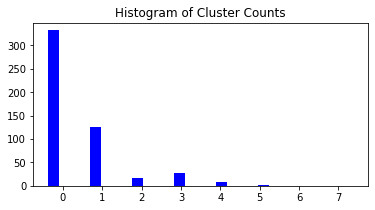

In [204]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=15,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

### 4.2 Access the k-means model attributes
The following code extracts the cluster centroids and converts them into a dataframe for visual analysis.

In [205]:
cluster_centers = kmeans.cluster_centers_ # returns ndarray of shape (n_clusters, n_features)
cluster_centroids = pd.DataFrame(cluster_centers)
cluster_centroids.columns = crash_data_transform.columns
print(cluster_centroids.shape)
display(cluster_centroids)

(6, 16)


,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,labels
0,-0.391107,0.042420,0.016741,0.012857,-0.003233,-0.001588,0.012432,0.009669,0.007571,0.003955,0.002946,0.010937,0.001285,0.007133,-0.013334,1.000000e+00
1,0.230623,-0.074029,-0.075817,-0.022320,0.027505,-0.010390,-0.057980,-0.021733,-0.027628,-0.003212,0.003390,-0.015268,-0.007878,0.000960,0.041628,5.000000e+00
2,2.017479,-0.795516,-0.022903,0.211307,0.093901,0.075305,0.110668,-0.134373,0.034460,0.066140,0.117869,0.128237,0.067780,0.009467,-0.017542,3.000000e+00
3,1.186172,-0.010616,0.144353,-0.157723,-0.116626,-0.003606,0.042804,0.028395,0.006065,-0.105555,-0.133162,-0.145057,-0.040217,-0.104919,-0.017553,8.881784e-16
4,3.390171,0.813210,0.112615,-0.254514,-0.305140,0.183078,0.077533,-0.024754,0.057459,0.165881,0.057981,0.014825,0.120827,-0.083387,0.051809,4.000000e+00
5,6.388394,2.485705,-0.634243,1.381483,1.745732,-0.817760,-0.579996,1.193890,-0.275265,-0.407486,-0.140981,0.040397,-0.434722,0.955814,-0.401521,2.000000e+00


### 4.3 Visualizing Centroids in Component Space
The following heatmap shows centroids of each cluster against their makeup of each PCA component. Based on this heatmap, clusters 1 and 3 have the highest values in component c_1. This means that county-municipalities within cluster 1 or 3 have similar crash attributes that are described in component c_1.

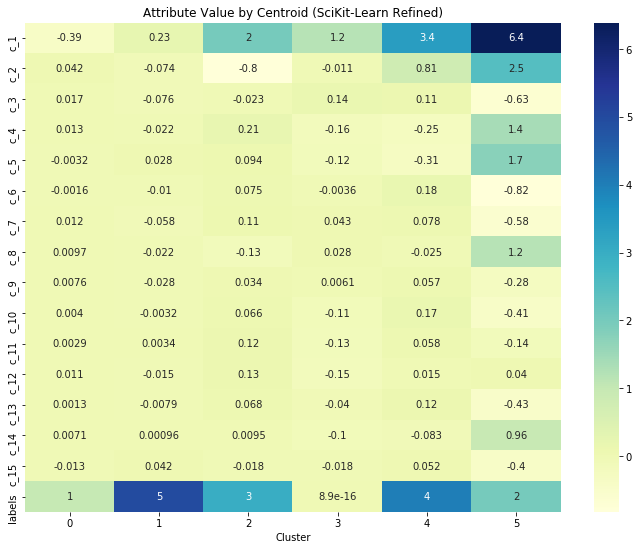

In [206]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu', annot=True)
ax.set_xlabel("Cluster")
ax.set_title("Attribute Value by Centroid (SciKit-Learn Refined)")
plt.show()

### 4.4 Natural Groupings

The following code maps the cluster labels back to each individual county-municipality data point. This is helpful when examining which counties are naturally grouped together.

In [207]:
# add a 'labels' column to the dataframe
crash_data_transform['labels']=list(map(int, cluster_labels))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [208]:
cluster=crash_data_transform[crash_data_transform['labels']==1]
cluster.head(100)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,labels
location,,,,,,,,,,,,,,,,
ATLANTIC-BUENA VISTA TWP,0.112528,-0.313396,-0.036641,0.397123,-0.139602,0.076991,-0.046225,-0.126018,0.151448,0.113910,-0.100951,0.093135,-0.070809,0.134052,0.247760,1
ATLANTIC-HAMMONTON TOWN,0.447787,-0.380913,0.246163,-0.185714,0.100283,-0.127983,-0.076863,0.131846,0.151921,-0.003605,-0.033353,0.067243,-0.053949,0.064706,-0.119843,1
ATLANTIC-MULLICA TWP,0.327265,-0.395221,-0.090052,0.162878,0.096830,0.002567,0.137025,0.000022,0.379356,0.070590,0.371107,-0.579768,-0.271997,-0.087073,0.494944,1
BERGEN-EAST RUTHERFORD BORO,0.070445,0.187891,-0.248225,-0.140380,-0.160201,-0.001805,-0.018386,0.037697,-0.186469,0.150110,-0.052271,-0.039408,-0.063981,-0.077912,-0.402040,1
BERGEN-ELMWOOD PARK BORO,0.025104,0.228387,-0.202587,-0.199717,0.004709,0.349037,0.072020,-0.091905,0.153180,-0.018630,-0.056261,0.009290,-0.025158,0.160823,0.021742,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SALEM-CARNEYS POINT TWP,0.646934,-0.484853,-0.402957,0.275575,0.016090,0.364481,-0.026602,-0.314439,0.224597,0.087695,-0.007508,-0.200135,-0.248403,0.252073,0.569575,1
SALEM-PILESGROVE TWP,0.178703,-0.105235,-0.234015,0.227077,-0.201007,0.012099,0.023228,-0.084510,-0.020883,0.053089,-0.136078,-0.051906,-0.177139,-0.007972,0.124517,1
SALEM-PITTSGROVE TWP,0.226843,-0.403678,0.149801,-0.114076,0.108660,0.045632,-0.166577,0.116834,-0.071603,-0.032876,0.002075,0.006551,0.110244,0.303576,0.121683,1


In [209]:
folder = 'processed_data/scikit-learn/'
cluster.to_csv(folder + 'cluster_refined.csv')
crash_data_scaled.to_csv(folder + 'crash_data_scaled.csv')
cluster_centroids.to_csv(folder + 'cluster_centroids.csv')
cluster_df.to_csv(folder + 'cluster_df.csv')

## Analysis of Results
The results from training the PCA and K-means models from this notebook will be discussed in the Capstone report.

In [210]:
for i in range(0,8):
    cluster_temp=crash_data_transform[crash_data_transform['labels']==i]
    print(i)
    print(cluster_temp.index.tolist())

0
['ATLANTIC-ABSECON CITY', 'ATLANTIC-BUENA BORO', 'ATLANTIC-EGG HARBOR CITY', 'ATLANTIC-ESTELL MANOR CITY', 'ATLANTIC-FOLSOM BORO', 'ATLANTIC-LINWOOD CITY', 'ATLANTIC-LONGPORT BORO', 'ATLANTIC-MARGATE CITY', 'ATLANTIC-NORTHFIELD CITY', 'ATLANTIC-PORT REPUBLIC CITY', 'ATLANTIC-SOMERS POINT CITY', 'ATLANTIC-VENTNOR CITY', 'ATLANTIC-WEYMOUTH TWP', 'BERGEN-ALLENDALE BORO', 'BERGEN-ALPINE BORO', 'BERGEN-BERGENFIELD BORO', 'BERGEN-BOGOTA BORO', 'BERGEN-CARLSTADT BORO', 'BERGEN-CLIFFSIDE PARK BORO', 'BERGEN-CLOSTER BORO', 'BERGEN-CRESSKILL BORO', 'BERGEN-DEMAREST BORO', 'BERGEN-DUMONT BORO', 'BERGEN-EDGEWATER BORO', 'BERGEN-EMERSON BORO', 'BERGEN-ENGLEWOOD CLIFFS BORO', 'BERGEN-FAIR LAWN BORO', 'BERGEN-FAIRVIEW BORO', 'BERGEN-GARFIELD CITY', 'BERGEN-GLEN ROCK BORO', 'BERGEN-HARRINGTON PARK BORO', 'BERGEN-HASBROUCK HEIGHTS BORO', 'BERGEN-HILLSDALE BORO', 'BERGEN-HO HO KUS BORO', 'BERGEN-LEONIA BORO', 'BERGEN-LITTLE FERRY BORO', 'BERGEN-LODI BORO', 'BERGEN-LYNDHURST TWP', 'BERGEN-MAYWOOD BORO'